<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_ElegantRL.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version**



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [2]:
## install finrl library
!pip install wrds
!pip install swig
!pip install finrl==0.3.5

## instal elegantrl
# !pip install elegantrl==0.3.3

!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

  Using cached finrl-0.3.5-py3-none-any.whl (85 kB)
INFO: pip is looking at multiple versions of finrl to determine which version is compatible with other requirements. This could take a while.


ERROR: Could not find a version that satisfies the requirement ccxt==1.66.32 (from finrl) (from versions: 1.0.0, 1.0.1, 1.3.1, 1.4.1, 1.5.1, 1.6.1, 1.7.1, 1.8.1, 1.9.1, 1.10.1, 1.11.1, 1.12.1, 1.13.1, 1.14.1, 1.15.1, 1.16.1, 1.17.1, 1.18.1, 1.19.1, 1.20.1, 1.21.1, 1.22.1, 1.23.1, 1.24.1, 1.26.1, 1.27.1, 1.28.1, 1.29.1, 1.30.1, 1.31.1, 1.32.1, 1.33.1, 1.34.1, 1.35.1, 1.36.1, 1.37.1, 1.38.1, 1.39.1, 1.40.1, 1.41.1, 1.42.1, 1.43.1, 1.44.1, 1.45.1, 1.46.1, 1.47.1, 1.48.1, 1.49.1, 1.50.1, 1.51.1, 1.52.1, 1.53.1, 1.54.1, 1.55.1, 1.56.1, 1.57.1, 1.58.1, 1.59.1, 1.60.1, 1.61.1, 1.62.1, 1.63.1, 1.64.1, 1.65.1, 1.66.1, 1.67.1, 1.68.1, 1.69.1, 1.70.1, 1.71.1, 1.72.1, 1.73.1, 1.74.1, 1.75.1, 1.76.1, 1.77.1, 1.78.1, 1.79.1, 1.80.1, 1.81.1, 1.82.1, 1.83.1, 1.84.1, 1.85.1, 1.86.1, 1.87.1, 1.88.1, 1.89.1, 1.90.1, 1.91.1, 1.92.1, 1.93.1, 1.95.1, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.0.10, 2.0.11, 2.0.12, 2.0.13, 2.0.14, 2.0.15, 2.0.16, 2.0.17, 2.0.18, 2.0.19, 2.0.20, 2.0.21, 

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to c:\users\adiln\appdata\local\temp\pip-req-build-0rj_9xf2
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit b8009990dceb15f214ed67458c3f4a41838d2d14
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to c:\users\adiln\appdata\local\temp\pip-install-hasyzwmv\elegantrl_cc4ae99ed3b24562a295174ea236c256
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit b4b9d662b9f9cb7cc368ac2b1036b5119eb20be4
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git 'C:\Users\adiln\AppData\Local\Temp\pip-req-build-0rj_9xf2'
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git 'C:\Users\adiln\AppData\Local\Temp\pip-install-hasyzwmv\elegantrl_cc4ae99ed3b24562a295174ea236c256'



<a id='1.2'></a>
## 2.2. A list of Python packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.agents.elegantrl.models import DRLAgent
from finrl.agents.stablebaselines3.models import DRLAgent

from stable_baselines3.common.logger import configure
# from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

# from elegantrl.agent import AgentDDPG
# from elegantrl.agent import AgentPPO
# from elegantrl.agent import AgentTD3
# from elegantrl.agent import AgentSAC

import sys
sys.path.append("../FinRL")



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [63]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [140]:
tickers_list = ['MSFT', 'AAPL', 'CAT', 'CSCO', 'NKE']

df = YahooDownloader(start_date = '2012-01-01',
                     end_date = '2023-10-31',
                     ticker_list = tickers_list).fetch_data()

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Shape of DataFrame:  (14880, 8)


In [141]:
print(tickers_list)

['MSFT', 'AAPL', 'CAT', 'CSCO', 'NKE']


In [142]:
df.shape

(14880, 8)

In [143]:
# df.sort_values(['date','tic'],ignore_index=True).head()
df.sort_values(['date'],ignore_index=True)

,date,open,high,low,close,volume,tic,day
0,2012-01-03,14.621429,14.732143,14.607143,12.449691,302220800,AAPL,1
1,2012-01-03,92.769997,95.110001,92.769997,67.953033,8177000,CAT,1
2,2012-01-03,18.549999,18.860001,18.480000,12.924060,41236600,CSCO,1
3,2012-01-03,26.549999,26.959999,26.389999,21.278027,64731500,MSFT,1
4,2012-01-03,24.342501,24.497499,24.174999,21.074888,10944400,NKE,1
...,...,...,...,...,...,...,...,...
14875,2023-10-30,333.410004,339.450012,331.829987,336.626770,22828100,MSFT,0
14876,2023-10-30,169.020004,171.169998,168.869995,170.065933,51131000,AAPL,0
14877,2023-10-30,240.940002,243.600006,239.179993,242.160004,4478300,CAT,0
14878,2023-10-30,51.349998,51.639999,51.090000,51.171814,13322400,CSCO,0


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [218]:
feature_engineer = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False)

states_df = feature_engineer.preprocess_data(df)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (2975, 8)
Successfully added vix


Successfully added turbulence index


In [221]:
from itertools import product
dates = list(pd.date_range(states_df['date'].min(),states_df['date'].max()).astype(str))

preprocessed_df = pd.DataFrame(list(product(dates,tickers_list)),columns=["date","tic"])
preprocessed_df = preprocessed_df.merge(states_df,how="left",on=["date","tic"],)
preprocessed_df = preprocessed_df[preprocessed_df['date'].isin(states_df['date'])]
preprocessed_df = preprocessed_df.sort_values(['date','tic'])

preprocessed_df = preprocessed_df.fillna(0)



In [228]:
preprocessed_df.describe()

,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
count,14875.000000,14875.000000,14875.000000,14875.000000,1.487500e+04,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000,14875.000000
mean,87.925341,88.823777,87.011258,81.711926,5.318533e+07,2.024874,0.364079,85.793759,76.633687,53.993699,25.419955,24.035344,80.960192,80.175403,17.832192,5.082796
std,69.802263,70.572683,68.999996,69.519045,1.044569e+08,1.398985,1.978481,73.222779,65.009080,9.108034,112.768150,17.081371,68.799795,68.013647,6.851859,9.983661
min,13.856071,14.271429,13.753571,10.578130,5.857000e+05,0.000000,-9.607837,11.796428,10.061000,25.806108,-519.458584,0.002358,11.423214,11.510131,9.140000,0.000000
25%,35.806250,36.121250,35.495001,31.222950,6.484750e+06,1.000000,-0.265390,32.151749,29.122308,47.574083,-60.106052,10.040956,30.320553,29.099533,13.370000,1.100472
50%,58.730000,59.349998,58.250000,54.248791,1.986530e+07,2.000000,0.231523,56.488091,51.163770,53.864361,43.015938,21.417965,53.548152,53.097535,16.070000,2.442859
75%,123.434998,124.844997,121.505001,116.092113,4.488855e+07,3.000000,0.905559,123.432460,105.970703,59.981706,108.892133,35.287715,114.693447,114.526894,20.549999,5.185750
max,361.750000,366.779999,352.440002,358.003845,1.506120e+09,4.000000,13.481133,358.153223,327.322526,100.000000,666.479161,100.000000,338.987468,332.702074,82.690002,137.878049


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2023-10-31


In [225]:
train = data_split(preprocessed_df, '2012-01-01','2020-07-01')
test = data_split(preprocessed_df, '2020-07-01','2023-10-31')


In [226]:
train

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2012-01-03,AAPL,14.621429,14.732143,14.607143,12.449691,302220800.0,1.0,0.000000,12.577765,12.388524,100.000000,66.666667,100.000000,12.449691,12.449691,22.969999,0.000000
0,2012-01-03,CAT,92.769997,95.110001,92.769997,67.953033,8177000.0,1.0,0.000000,12.577765,12.388524,100.000000,66.666667,100.000000,67.953033,67.953033,22.969999,0.000000
0,2012-01-03,CSCO,18.549999,18.860001,18.480000,12.924060,41236600.0,1.0,0.000000,12.577765,12.388524,100.000000,66.666667,100.000000,12.924060,12.924060,22.969999,0.000000
0,2012-01-03,MSFT,26.549999,26.959999,26.389999,21.278027,64731500.0,1.0,0.000000,12.577765,12.388524,100.000000,66.666667,100.000000,21.278027,21.278027,22.969999,0.000000
0,2012-01-03,NKE,24.342501,24.497499,24.174999,21.074888,10944400.0,1.0,0.000000,12.577765,12.388524,100.000000,66.666667,100.000000,21.074888,21.074888,22.969999,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,2020-06-30,AAPL,90.019997,91.495003,90.000000,89.301910,140223200.0,1.0,3.047959,91.772525,78.668559,63.073206,107.459091,28.116947,82.797500,76.632958,30.430000,3.059549
2136,2020-06-30,CAT,124.010002,127.059998,124.010002,117.040138,2778800.0,1.0,1.278039,126.300949,109.645478,53.144620,22.194052,8.424421,115.004342,109.757678,30.430000,3.059549
2136,2020-06-30,CSCO,46.150002,47.009998,46.099998,41.582500,21888800.0,1.0,0.264298,43.242786,39.032444,54.483992,47.393300,14.675050,41.006555,39.310505,30.430000,3.059549
2136,2020-06-30,MSFT,197.880005,204.399994,197.740005,197.193298,34310300.0,1.0,4.655630,199.382236,175.765609,60.679253,130.573181,29.201117,184.204036,176.992381,30.430000,3.059549


In [227]:
test

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.132996,110737200.0,2.0,2.988731,91.903733,79.491813,62.807132,107.505376,29.730532,83.213409,77.050535,28.620001,1.158789
0,2020-07-01,CAT,129.380005,129.399994,125.879997,116.633041,2807800.0,2.0,1.230243,126.273510,109.577621,52.865425,35.773266,14.457404,115.435494,109.861389,28.620001,1.158789
0,2020-07-01,CSCO,46.540001,46.720001,46.000000,41.065392,17129500.0,2.0,0.257262,43.176735,39.020038,53.160527,19.389837,13.380576,41.049647,39.379303,28.620001,1.158789
0,2020-07-01,MSFT,203.139999,206.350006,201.770004,198.346329,32061200.0,2.0,4.892476,200.627275,176.394542,61.184890,140.812811,33.015146,184.901042,177.636563,28.620001,1.158789
0,2020-07-01,NKE,98.500000,98.720001,97.110001,94.027031,5733800.0,2.0,0.604544,101.314975,90.103411,52.347806,-25.373779,10.077761,95.259393,89.802712,28.620001,1.158789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,2023-10-27,AAPL,166.910004,168.960007,166.830002,167.998672,58499100.0,4.0,-1.928420,182.400054,167.304235,41.106552,-159.559754,44.522007,174.545713,176.867997,21.270000,3.086772
837,2023-10-27,CAT,243.050003,243.919998,237.860001,238.559998,3229900.0,4.0,-7.770853,282.027943,237.547927,37.176349,-185.800870,57.104296,264.389057,271.011240,21.270000,3.086772
837,2023-10-27,CSCO,51.639999,52.150002,51.400002,51.161896,13333900.0,4.0,-0.579820,54.460451,51.251966,42.589506,-186.003431,38.086601,53.016064,53.783767,21.270000,3.086772
837,2023-10-27,MSFT,330.429993,336.720001,328.399994,329.141968,29856500.0,4.0,1.856144,339.244674,315.557319,51.322881,66.282036,1.795524,324.281493,325.163122,21.270000,3.086772


array(['AAPL', 'CAT', 'CSCO', 'MSFT', 'NKE'], dtype=object)

In [239]:
stock_size = len(tickers_list)
state_space = 1 + 2*stock_size + len(['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'])*stock_size

# 8 indictor/price features PER stock (there's 5 here)
# Plus, the raw price data is captured again as 2 extra features per stock (typically Open and Close price).
# So + 2N state variables
# Hence 8*5 (indicators) + 2*5 (raw price) + 1 (offset variable)

stock_size, state_space

(5, 51)

In [234]:

kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": [0] * stock_size,
    "buy_cost_pct": [0.001] * stock_size,
    "sell_cost_pct": [0.001] * stock_size,
    "state_space": state_space,
    "stock_dim": stock_size,
    "tech_indicator_list": ['macd',
    'boll_ub',
    'boll_lb',
    'rsi_30',
    'cci_30',
    'dx_30',
    'close_30_sma',
    'close_60_sma'],
    "action_space": stock_size,
    "reward_scaling": 1e-4
}


stock_trading_env = StockTradingEnv(df = train, **kwargs)


## Environment for Training



In [235]:
env_train, _ = stock_trading_env.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


### Agent 1: A2C


In [215]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

tmp_path = RESULTS_DIR + '/a2c'
new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [216]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=50000) 

---------------------------------------
| time/                 |             |
|    fps                | 362         |
|    iterations         | 100         |
|    time_elapsed       | 1           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -7.11       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 11.9        |
|    reward             | 0.002501607 |
|    std                | 1           |
|    value_loss         | 4.12        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 367       |
|    iterations         | 200       |
|    time_elapsed       | 2         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -7.09     |
|    explained_variance | 0         |
|    learning_rate

### Agent 2: DDPG

In [85]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

# set up logger
tmp_path = RESULTS_DIR + '/ddpg'
new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [86]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000)

KeyboardInterrupt: 

### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

# set up logger
tmp_path = RESULTS_DIR + '/a2c'
new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# Set new logger
model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/a2c


In [164]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=50000)

-----------------------------------------
| time/                   |             |
|    fps                  | 556         |
|    iterations           | 1           |
|    time_elapsed         | 3           |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.008732445 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.1        |
|    explained_variance   | 0.293       |
|    learning_rate        | 0.00025     |
|    loss                 | 17.2        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.00872    |
|    reward               | -8.01567    |
|    std                  | 1           |
|    value_loss           | 33          |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 519          |
|    iterations           | 2  

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [165]:
data_risk_indicator = preprocessed_df[(preprocessed_df.date<'2020-07-01') & (preprocessed_df.date>='2012-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [166]:
insample_risk_indicator.vix.describe()

count    2048.000000
mean       17.863091
std         6.789542
min         9.140000
25%        13.370000
50%        16.075000
75%        20.600000
max        76.449997
Name: vix, dtype: float64

In [167]:
insample_risk_indicator.vix.quantile(0.996)

56.5712009429929

In [168]:
insample_risk_indicator.turbulence.describe()

count    2048.000000
mean        5.149548
std        10.144291
min         0.000000
25%         1.131800
50%         2.490098
75%         5.267782
max       137.878049
Name: turbulence, dtype: float64

In [169]:
insample_risk_indicator.turbulence.quantile(0.996)

87.14247203616236

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of test date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [170]:
e_trade_gym = StockTradingEnv(df = test, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [171]:
trade

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2020-07-01,CAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2020-07-01,CSCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2020-07-01,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2020-07-01,NKE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,2023-10-27,AAPL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,2023-10-27,CAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,2023-10-27,CSCO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,2023-10-27,MSFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [172]:
# trained_model_ddpg = trained_ddpg
# df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
#     model=trained_model_ddpg,
#     environment = e_trade_gym)


trained_model_a2c = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model_a2c,
    environment = e_trade_gym)

trained_model_ppo = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_model_ppo,
    environment = e_trade_gym)



ValueError: Expected parameter loc (Tensor of shape (1, 5)) of distribution Normal(loc: torch.Size([1, 5]), scale: torch.Size([1, 5])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan]])

In [ ]:
df_account_value_ddpg

,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.000604e+06
2,2020-07-06,1.008922e+06
3,2020-07-07,9.971311e+05
4,2020-07-08,1.002399e+06
...,...,...
331,2021-10-22,1.416524e+06
332,2021-10-25,1.419844e+06
333,2021-10-26,1.419663e+06
334,2021-10-27,1.406674e+06


In [ ]:
df_account_value_a2c

,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.000221e+06
2,2020-07-06,1.001346e+06
3,2020-07-07,9.997694e+05
4,2020-07-08,1.002199e+06
...,...,...
833,2023-10-23,1.442205e+06
834,2023-10-24,1.454256e+06
835,2023-10-25,1.482375e+06
836,2023-10-26,1.428001e+06


In [ ]:
df_actions_a2c

,AAPL,CAT,CSCO,MSFT,NKE
date,,,,,
2020-07-01,0,0,0,100,100
2020-07-02,0,0,0,100,100
2020-07-06,0,0,0,100,100
2020-07-07,0,0,0,100,100
2020-07-08,0,0,0,100,100
...,...,...,...,...,...
2023-10-20,0,0,0,0,0
2023-10-23,0,0,0,0,0
2023-10-24,0,0,0,0,0


In [ ]:
df_account_value_ppo

,date,account_value
0,2020-07-01,1.000000e+06
1,2020-07-02,1.000111e+06
2,2020-07-06,1.000605e+06
3,2020-07-07,9.998996e+05
4,2020-07-08,1.000702e+06
...,...,...
833,2023-10-23,1.351638e+06
834,2023-10-24,1.369367e+06
835,2023-10-25,1.348274e+06
836,2023-10-26,1.315018e+06


In [ ]:
df_actions_ppo

,AAPL,CAT,CSCO,MSFT,NKE
date,,,,,
2020-07-01,28,55,19,12,24
2020-07-02,28,55,19,12,24
2020-07-06,28,55,19,12,24
2020-07-07,28,55,19,12,24
2020-07-08,28,55,19,12,24
...,...,...,...,...,...
2023-10-20,0,0,0,0,0
2023-10-23,0,0,0,0,0
2023-10-24,0,0,0,0,0


In [98]:
df_actions_ddpg

,date,actions
0,2020-07-01,[0]
1,2020-07-02,[0]
2,2020-07-06,[0]
3,2020-07-07,[0]
4,2020-07-08,[0]
...,...,...
832,2023-10-20,[0]
833,2023-10-23,[0]
834,2023-10-24,[0]
835,2023-10-25,[0]


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [ ]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.082748
Cumulative returns     0.302620
Annual volatility      0.227323
Sharpe ratio           0.463752
Calmar ratio           0.225497
Stability              0.126186
Max drawdown          -0.366960
Omega ratio            1.085327
Sortino ratio          0.668923
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.064719
Daily value at risk   -0.028222
dtype: float64


C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

Annual return          0.112962
Cumulative returns     0.427465
Annual volatility      0.254000
Sharpe ratio           0.548809
Calmar ratio           0.276978
Stability              0.148515
Max drawdown          -0.407837
Omega ratio            1.097398
Sortino ratio          0.793266
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.106982
Daily value at risk   -0.031448
dtype: float64


C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (837, 8)
Annual return          0.075612
Cumulative returns     0.273920
Annual volatility      0.154568
Sharpe ratio           0.549480
Calmar ratio           0.344619
Stability              0.251243
Max drawdown          -0.219408
Omega ratio            1.096731
Sortino ratio          0.782356
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.001898
Daily value at risk   -0.019137
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
#baseline stats
baseline_df = get_baseline(
        ticker="^DJI",
        start = df_account_value_ppo.loc[0,'date'],
        end = df_account_value_ppo.loc[len(df_account_value_ppo)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (837, 8)
Annual return          0.075612
Cumulative returns     0.273920
Annual volatility      0.154568
Sharpe ratio           0.549480
Calmar ratio           0.344619
Stability              0.251243
Max drawdown          -0.219408
Omega ratio            1.096731
Sortino ratio          0.782356
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.001898
Daily value at risk   -0.019137
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
df_account_value_a2c['date']

0      2020-07-01
1      2020-07-02
2      2020-07-06
3      2020-07-07
4      2020-07-08
          ...    
833    2023-10-23
834    2023-10-24
835    2023-10-25
836    2023-10-26
837    2023-10-27
Name: date, Length: 838, dtype: object

In [ ]:
df_account_value_a2c.loc[0,'date']

'2020-07-01'

In [ ]:
df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date']

'2023-10-27'

In [ ]:
import pyfolio
import pandas as pd
from pandas_datareader import data as pdr

def BackTestPlot(strategy_returns, 
                 baseline_start, 
                 baseline_end,
                 baseline_ticker='^DJI'):

    # Get benchmark returns
    benchmark_returns = pdr.get_data_yahoo(
        baseline_ticker, 
        start=baseline_start, 
        end=baseline_end)['Close'].pct_change()

    # Ensure datetime indexes
    strategy_returns.index = pd.to_datetime(strategy_returns.index)
    benchmark_returns.index = pd.to_datetime(benchmark_returns.index)

    # Plot tear sheet
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_returns_tear_sheet(
            returns=strategy_returns,
            benchmark_rets=benchmark_returns,
            set_context=False
        )


<a id='6.2'></a>
## 7.2 BackTestPlot

In [ ]:
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

backtest_plot(df_account_value_a2c,
             baseline_ticker = '^NDX',
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (837, 8)



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-07-01
End date,2023-10-27
Total months,39
,Backtest
Annual return,11.3%
Cumulative returns,42.7%
Annual volatility,25.4%
Sharpe ratio,0.55
Calmar ratio,0.28
Stability,0.15
Max drawdown,-40.8%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

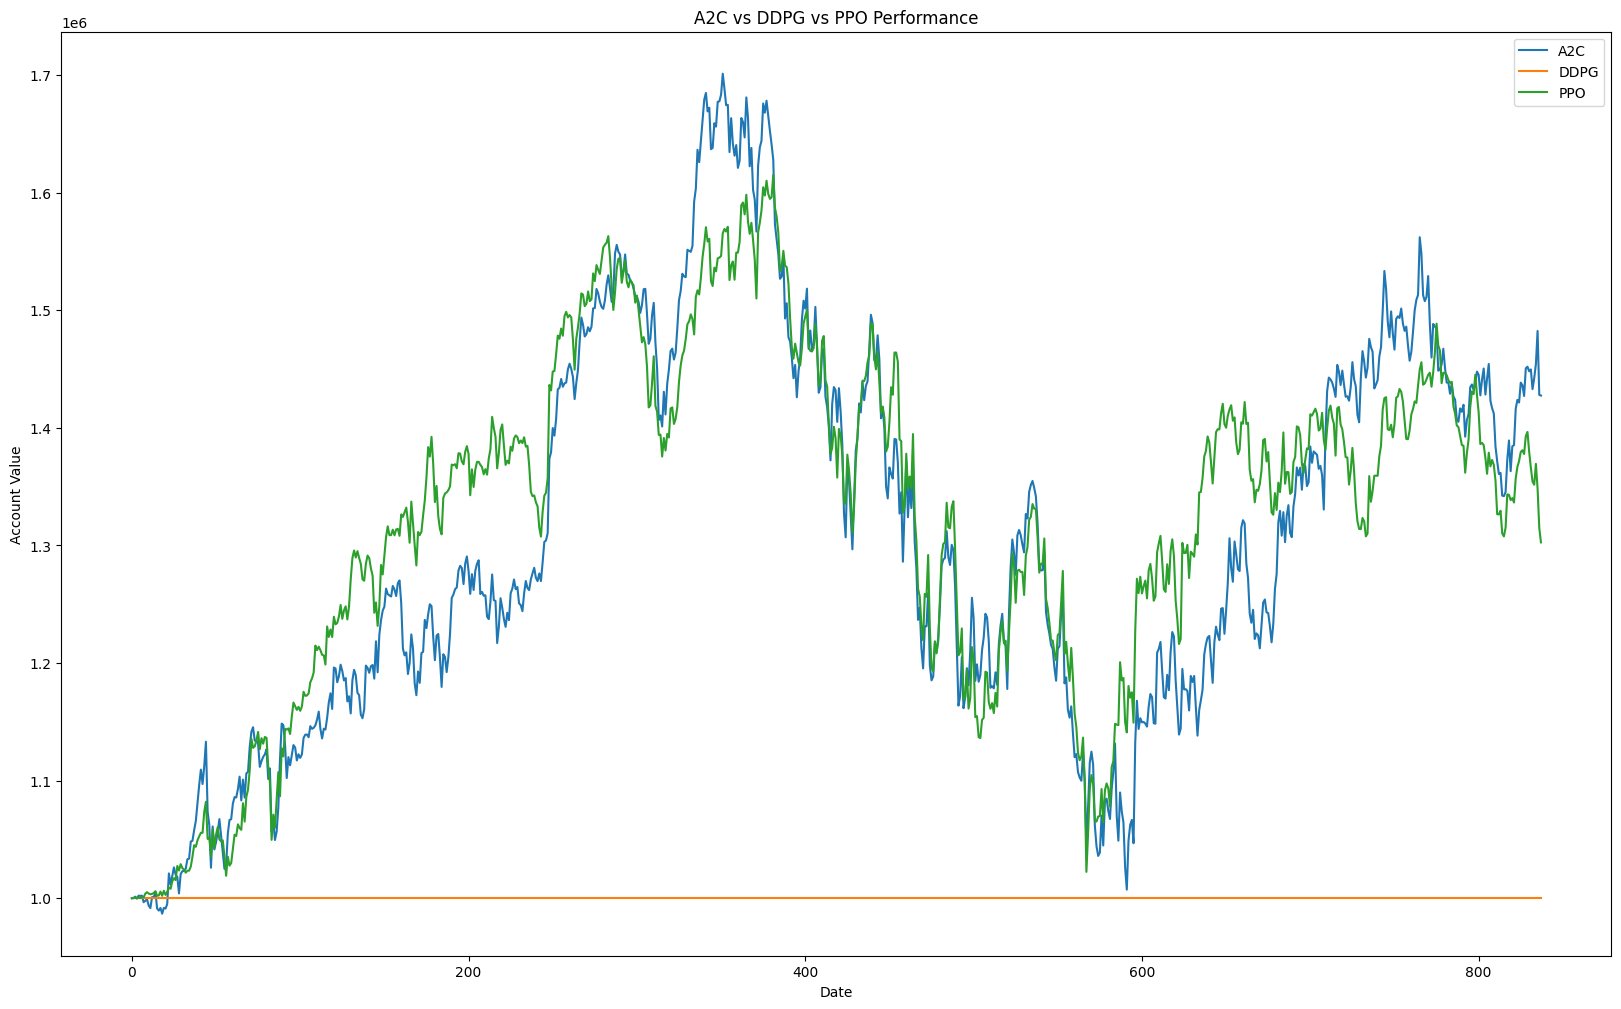

In [ ]:
df_account_value_a2c['account_value']
# df_account_value_ddpg['account_value']

plt.figure(figsize=(20, 12))
plt.plot(df_account_value_a2c.index, df_account_value_a2c['account_value'], label='A2C')
# plt.plot(df_account_value_ddpg.index, df_account_value_ddpg['account_value'], label='DDPG')
plt.plot(df_account_value_ppo.index, df_account_value_ppo['account_value'], label='PPO')


plt.title('A2C vs DDPG vs PPO Performance')
plt.xlabel('Date')
plt.ylabel('Account Value')
plt.legend()
plt.show()


In [ ]:
df_ndx_ = get_baseline(
        ticker="^NDX", 
        start = '2020-07-01',
        end = '2023-10-31')
stats = backtest_stats(df_ndx_, value_col_name = 'close')
df_ndx = pd.DataFrame()
df_ndx['date'] = df_account_value_ppo['date']
df_ndx['account_value'] = df_ndx_['close'] / df_ndx_['close'][0] * env_kwargs["initial_amount"]


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (839, 8)
Annual return          0.105063
Cumulative returns     0.394607
Annual volatility      0.245297
Sharpe ratio           0.530538
Calmar ratio           0.295428
Stability              0.044324
Max drawdown          -0.355631
Omega ratio            1.092124
Sortino ratio          0.750085
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952510
Daily value at risk   -0.030388
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [128]:
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
df_ndx_ = get_baseline(
        ticker="^NDX", 
        start = '2020-07-01',
        end = '2023-10-31')
stats = backtest_stats(df_ndx_, value_col_name = 'close')
df_ndx = pd.DataFrame()
df_ndx['date'] = df_account_value_a2c['date']
df_ndx['account_value'] = df_ndx_['close'] / df_ndx_['close'][0] * env_kwargs["initial_amount"]


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (839, 8)
Annual return          0.105063
Cumulative returns     0.394607
Annual volatility      0.245297
Sharpe ratio           0.530538
Calmar ratio           0.295428
Stability              0.044324
Max drawdown          -0.355631
Omega ratio            1.092124
Sortino ratio          0.750085
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.952510
Daily value at risk   -0.030388
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
df_ndx_ = get_baseline(
        ticker="^GSPC", 
        start = '2020-07-01',
        end = '2023-10-31')
stats = backtest_stats(df_ndx_, value_col_name = 'close')
df_ndx = pd.DataFrame()
df_ndx['date'] = df_account_value_a2c['date']
df_ndx['account_value'] = df_ndx_['close'] / df_ndx_['close'][0] * env_kwargs["initial_amount"]


[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (839, 8)
Annual return          0.091222
Cumulative returns     0.337294
Annual volatility      0.177234
Sharpe ratio           0.581870
Calmar ratio           0.358788
Stability              0.220266
Max drawdown          -0.254251
Omega ratio            1.102582
Sortino ratio          0.825010
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.981756
Daily value at risk   -0.021920
dtype: float64



C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [108]:

from ray import tune
# from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.schedulers import AsyncHyperBandScheduler
# from ray.tune.suggest.optuna import OptunaSearch

def sample_ddpg_params():
  
  return {
  "buffer_size": tune.choice([int(1e4), int(1e5), int(1e6)]),
  "lr": tune.loguniform(1e-5, 1),
  "train_batch_size": tune.choice([32, 64, 128, 256, 512])
  }
def sample_a2c_params():
  
  return{
       "lambda": tune.choice([0.1,0.3,0.5,0.7,0.9,1.0]),
      "entropy_coeff": tune.loguniform(0.00000001, 0.1),
      "lr": tune.loguniform(1e-5, 1) 
      
  }

def sample_ppo_params():
  return {
      "entropy_coeff": tune.loguniform(0.00000001, 0.1),
      "lr": tune.loguniform(5e-5, 1),
      "sgd_minibatch_size": tune.choice([ 32, 64, 128, 256, 512]),
      "lambda": tune.choice([0.1,0.3,0.5,0.7,0.9,1.0])
  }

C:\Users\adiln\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-13 15:20:27,672	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-01-13 15:20:29,328	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
